In [1]:
import pandas as pd
import fbprophet
import matplotlib.pyplot as plt


Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv("monthly-milk-production-pounds.csv")

In [3]:
data.head()

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
data.tail()

,Month,Monthly milk production (pounds per cow)
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [5]:
data.columns=['ds','y']

In [6]:
data.head()

,ds,y
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [7]:
data['ds']=pd.to_datetime(data['ds'])

In [8]:
data.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


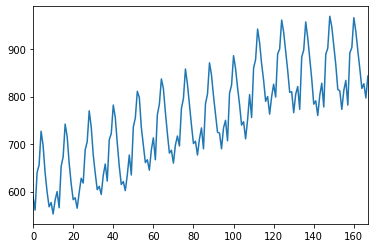

In [9]:
data['y'].plot()

#### To change into stationary value : required for ARIMA models but fbprophet does it automatically

In [10]:
#goes 1 step downward for first nan

#data['y'].shift(1)

In [11]:
#data['y']=data['y']-data['y'].shift(1)

In [12]:
data.head()

,ds,y
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


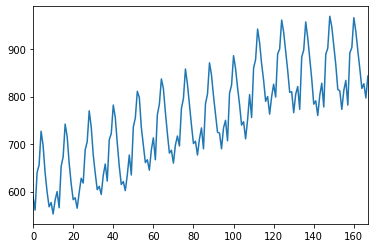

In [13]:
data['y'].plot()

In [14]:
from fbprophet import Prophet


In [15]:
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_column_matrix',
 'sample_model',
 'samp

In [16]:
model = Prophet()
model.fit(data) #data must be in format ds and y

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [18]:
data.tail()

,ds,y
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797
167,1975-12-01,843


In [19]:
# for predicting we need future date so creating 365 new date
future_dates=model.make_future_dataframe(periods=365)

In [20]:
future_dates.head()

,ds
0,1962-01-01
1,1962-02-01
2,1962-03-01
3,1962-04-01
4,1962-05-01


In [21]:
#prediction
prediction=model.predict(future_dates)

In [22]:
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
528,1976-11-26,814.771653,803.346741,826.502627
529,1976-11-27,818.063163,807.152356,828.903289
530,1976-11-28,821.527358,810.175067,832.820962
531,1976-11-29,825.098612,814.038534,837.337666
532,1976-11-30,828.704359,817.462653,840.683898



#### prophet has inbuilt function model.plot() to predict projection where blue shows prediction and black shows real data and light blue is for trend


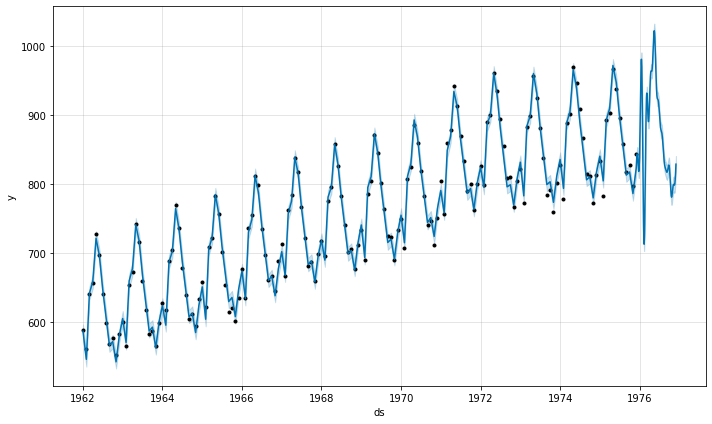

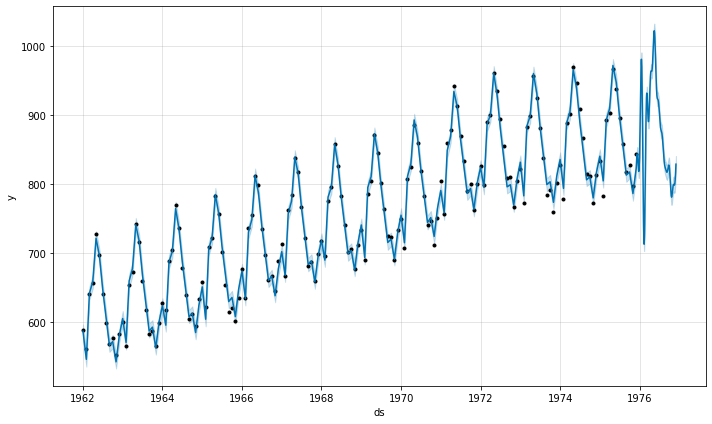

In [23]:
#### plot the predicted projection

model.plot(prediction)

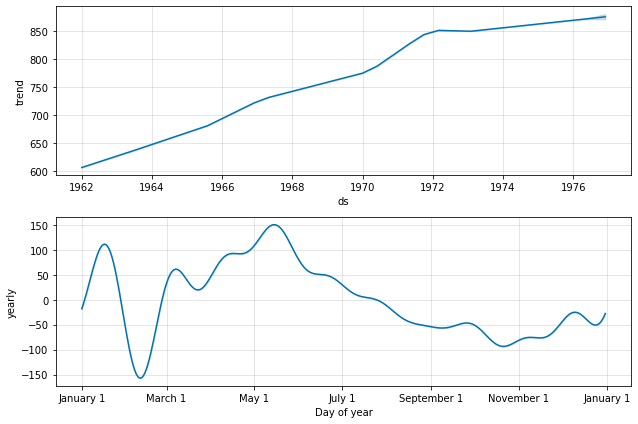

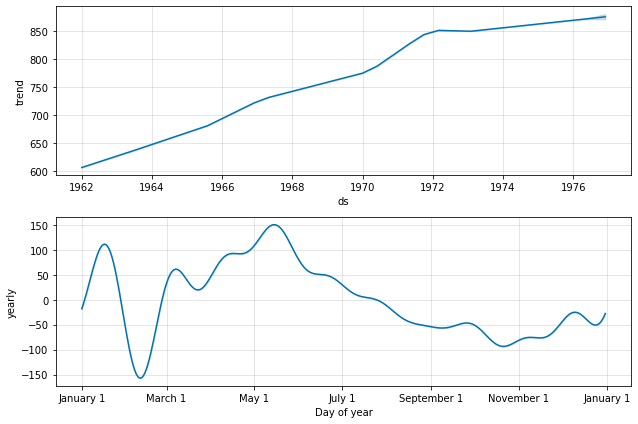

In [24]:
#### Visualize Each Components[Trend,Weekly]
model.plot_components(prediction)

### Cross Validation

Forecast error using historical data.compare predicted value with actual values. for this we select cut off points in history of data and fit data upto cutoff point. After that we compare values.cross_validation method allows us to do this on prophet.

1. horizon the forecast horizon. (begins with end data -horizon till end for cross validation)
2. initial the size of the initial training period
3. period the spacing betwee cutoff dates

In [25]:
from fbprophet.diagnostics import cross_validation

In [26]:
df_cv = cross_validation(model,horizon='365 days',initial='730 days',period='180 days')

INFO:fbprophet:Making 23 forecasts with cutoffs between 1964-01-28 00:00:00 and 1974-12-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


In [27]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1964-02-01,578.125014,577.218034,579.235536,618,1964-01-28
1,1964-03-01,673.630707,670.739749,677.098393,688,1964-01-28
2,1964-04-01,702.911754,696.358569,709.422467,705,1964-01-28
3,1964-05-01,783.224672,772.406212,793.075807,770,1964-01-28
4,1964-06-01,738.111533,723.095450,752.471921,736,1964-01-28


In [28]:
### performance metric:
from fbprophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cv)
df_performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,296.466171,17.218193,13.167650,0.017594,0.014528,0.370370
1,38 days,238.955117,15.458173,11.916743,0.015523,0.013585,0.370370
2,41 days,241.566120,15.542398,12.056927,0.015705,0.014528,0.370370
3,42 days,256.911206,16.028450,12.627614,0.016460,0.014573,0.333333
4,43 days,257.256831,16.039228,12.728317,0.016617,0.014573,0.333333


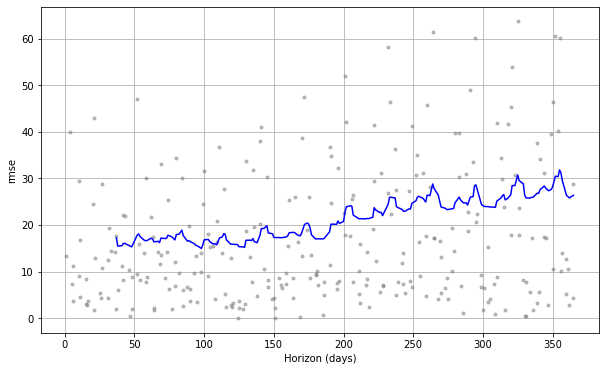

In [29]:
#ploting performance metric
from fbprophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='rmse')